# Issue 6: Rio Grande - examine individual events

In [1]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

## Definition of functions

In [2]:
def read_group(gruppe, loc):
    station = loc  # ersten Buchstaben bitte bitte groß schreiben

    if loc == "Rio":
        timestart = "2008-02-01"
        timeend = "2019-12-31"
    elif loc == "Col":
        timestart = "2004-08-01"
        timeend = "2019-03-06"
    elif loc == "CMA":
        timestart = "2002-01-01"
        timeend = "2018-12-31"
    elif loc == "Dav":
        timestart = "2005-01-01"
        timeend = "2019-12-31"
    elif loc == "Kir":
        timestart = "1999-08-01"
        timeend = "2019-12-31"

    infiles = f"{root_path}{station}/Meteor_radar_{station}_GW_*.h5"
    if gruppe == "tides":
        ds = xr.open_mfdataset(
            infiles,
            concat_dim="phony_dim_4",
            group=gruppe,
            combine="nested",
            parallel=True,
        )
        ds = ds.rename({"phony_dim_4": "time", "phony_dim_5": "alt"})
    else:
        ds = xr.open_mfdataset(
            infiles,
            concat_dim="phony_dim_6",
            group=gruppe,
            combine="nested",
            parallel=True,
        )
        ds = ds.rename({"phony_dim_6": "time", "phony_dim_7": "alt"})
    ds["alt"] = alt
    ds["alt"].attrs["units"] = "km"
    # change time range according to meteor radar station
    ds["time"] = pd.date_range(start=timestart, end=timeend, periods=ds.time.shape[0])
    return ds

In [3]:
def read_var(gruppe, var):
    varout = gruppe[var]
    return varout

In [4]:
def time_mean(step, var):
    return var.resample(time="1" + step).mean(
        "time"
    )  # Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!

In [5]:
def anomalie(step, var):
    string = "time." + step
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology

    return anomalies

In [6]:
def sea(days_period, station, var, ave_f=xr.DataArray.mean):
    df_dates = pd.read_csv(
        "ssw_dates_displ_" + station + "_without_final_warmings.csv"
    )  # you can load SSWs from a csv file like attached
    dates = df_dates.set_index("BeginDate")

    xa_ls = []
    max_lag = days_period
    for il, days in enumerate(range(-max_lag, max_lag + 1)):
        sel_dates = pd.to_datetime(dates.index) + pd.Timedelta(str(days) + " days")
        mask = np.in1d(var.time.dt.floor("1D"), sel_dates)
        comp_m = ave_f(var.sel(time=mask), "time")
        xa_ls.append(comp_m)

    xa_comp = xr.concat(xa_ls, dim="days")
    xa_comp["days"] = range(-max_lag, max_lag + 1)

    # print(xa_comp'
    return xa_comp

In [7]:
alt = [
    70,
    72,
    74,
    76,
    78,
    80,
    82,
    84,
    86,
    88,
    90,
    92,
    94,
    96,
    98,
    100,
    102,
    104,
    106,
    108,
    110,
    112,
    114,
    116,
    118,
    120,
]
root_path = "/home/gemeinsam_tmp/UA_students/data/"

## Rio Grande

### Hourly datasets without final warmings

#### Mean

In [8]:
ds_rio = read_group("wind", "Rio")
u_rio = read_var(ds_rio, "u")
v_rio = read_var(ds_rio, "v")

u_rio_anomalie = anomalie("day", u_rio)
# u_rio_anomalie.plot(x='time',robust=True)

v_rio_anomalie = anomalie("day", v_rio)

sea_u_rio = sea(30, "Rio", u_rio)
sea_u_rio_anomalie = sea(30, "Rio", u_rio_anomalie)

sea_v_rio = sea(30, "Rio", v_rio)
sea_v_rio_anomalie = sea(30, "Rio", v_rio_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


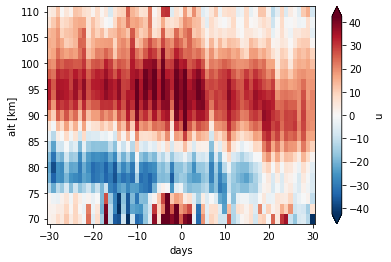

In [9]:
ax33 = sea_u_rio.sel(alt=slice(70, 110)).plot(x="days", robust=True)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


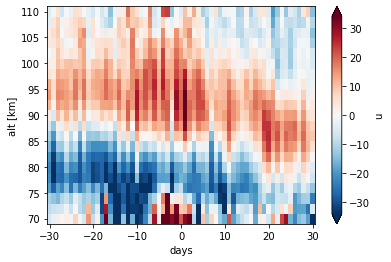

In [10]:
ax34 = sea_u_rio_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True)

#### Median

In [11]:
ds_rio = read_group("wind", "Rio")
u_rio = read_var(ds_rio, "u")
v_rio = read_var(ds_rio, "v")

u_rio_anomalie = anomalie("day", u_rio)
# u_rio_anomalie.plot(x='time',robust=True)

v_rio_anomalie = anomalie("day", v_rio)

sea_u_rio_med = sea(30, "Rio", u_rio, ave_f=xr.DataArray.median)
sea_u_rio_anomalie_med = sea(30, "Rio", u_rio_anomalie, ave_f=xr.DataArray.median)

sea_v_rio_med = sea(30, "Rio", v_rio, ave_f=xr.DataArray.median)
sea_v_rio_anomalie_med = sea(30, "Rio", v_rio_anomalie, ave_f=xr.DataArray.median)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


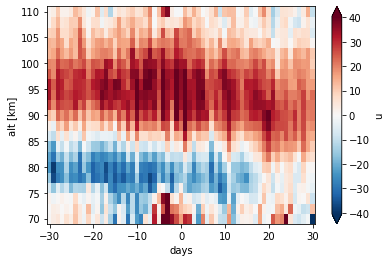

In [12]:
ax35 = sea_u_rio_med.sel(alt=slice(70, 110)).plot(x="days", robust=True)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


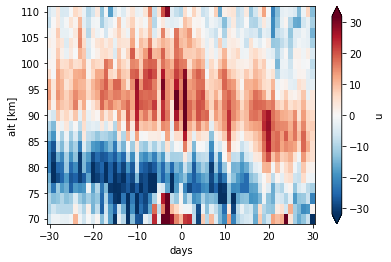

In [13]:
ax36 = sea_u_rio_anomalie_med.sel(alt=slice(70, 110)).plot(x="days", robust=True)

No obvious differences between using mean and median for the superposed epoch analysis of the zonal wind are apparent.

### Individual events

In [14]:
def sea_individual(days_period, station, var):
    df_dates = pd.read_csv(
        "ssw_dates_displ_" + station + "_without_final_warmings.csv"
    )  # you can load SSWs from a csv file like attached
    dates = df_dates.set_index("BeginDate")

    xa_ls = []

    print(dates.index)

    for days in dates.index:

        td = pd.Timedelta(
            str(days_period) + " days"
        )  # define timedelta e.g., +/- 30 days
        comp_m = var.sel(
            time=slice(pd.to_datetime(days) - td, pd.to_datetime(days) + td)
        )  # select the data in the time range around the SSW onset
        comp_m["time"] = np.linspace(
            -days_period, days_period, comp_m.time.shape[0]
        )  # set the time dimension of comp_m to an array of +/- the period
        xa_ls.append(comp_m)  # xa_ls is an array of the datasets of all single events

    xa_comp = xr.concat(
        xa_ls, dim="event"
    )  # assign 'event' as new dimension to the data array --> new array xa_comp
    xa_comp[
        "event"
    ] = (
        dates.index.values
    )  # xa_comp has now the dimension 'event' and the values of this dimension are the indices of dates (i.e. the dates of the SSW onsets)

    return xa_comp

In [15]:
sea_u_rio_individual = sea_individual(30, "Rio", u_rio)
sea_u_rio_individual_anomalie = sea_individual(30, "Rio", u_rio_anomalie)

sea_v_rio = sea_individual(30, "Rio", v_rio)
sea_v_rio_individual_anomalie = sea_individual(30, "Rio", v_rio_anomalie)

Index(['2009-01-24', '2010-02-09', '2013-01-06', '2018-02-12'], dtype='object', name='BeginDate')
Index(['2009-01-24', '2010-02-09', '2013-01-06', '2018-02-12'], dtype='object', name='BeginDate')
Index(['2009-01-24', '2010-02-09', '2013-01-06', '2018-02-12'], dtype='object', name='BeginDate')
Index(['2009-01-24', '2010-02-09', '2013-01-06', '2018-02-12'], dtype='object', name='BeginDate')


In [16]:
sea_u_rio_individual

<xarray.DataArray 'u' (event: 4, time: 2879, alt: 26)>
dask.array<concatenate, shape=(4, 2879, 26), dtype=float64, chunksize=(1, 639, 26), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 -30.0 -29.96 -29.96 -29.92 ... 29.96 29.96 30.0
  * alt      (alt) int64 70 72 74 76 78 80 82 84 ... 108 110 112 114 116 118 120
  * event    (event) object '2009-01-24' '2010-02-09' '2013-01-06' '2018-02-12'
Attributes:
    zonal wind:  zonal / m/s

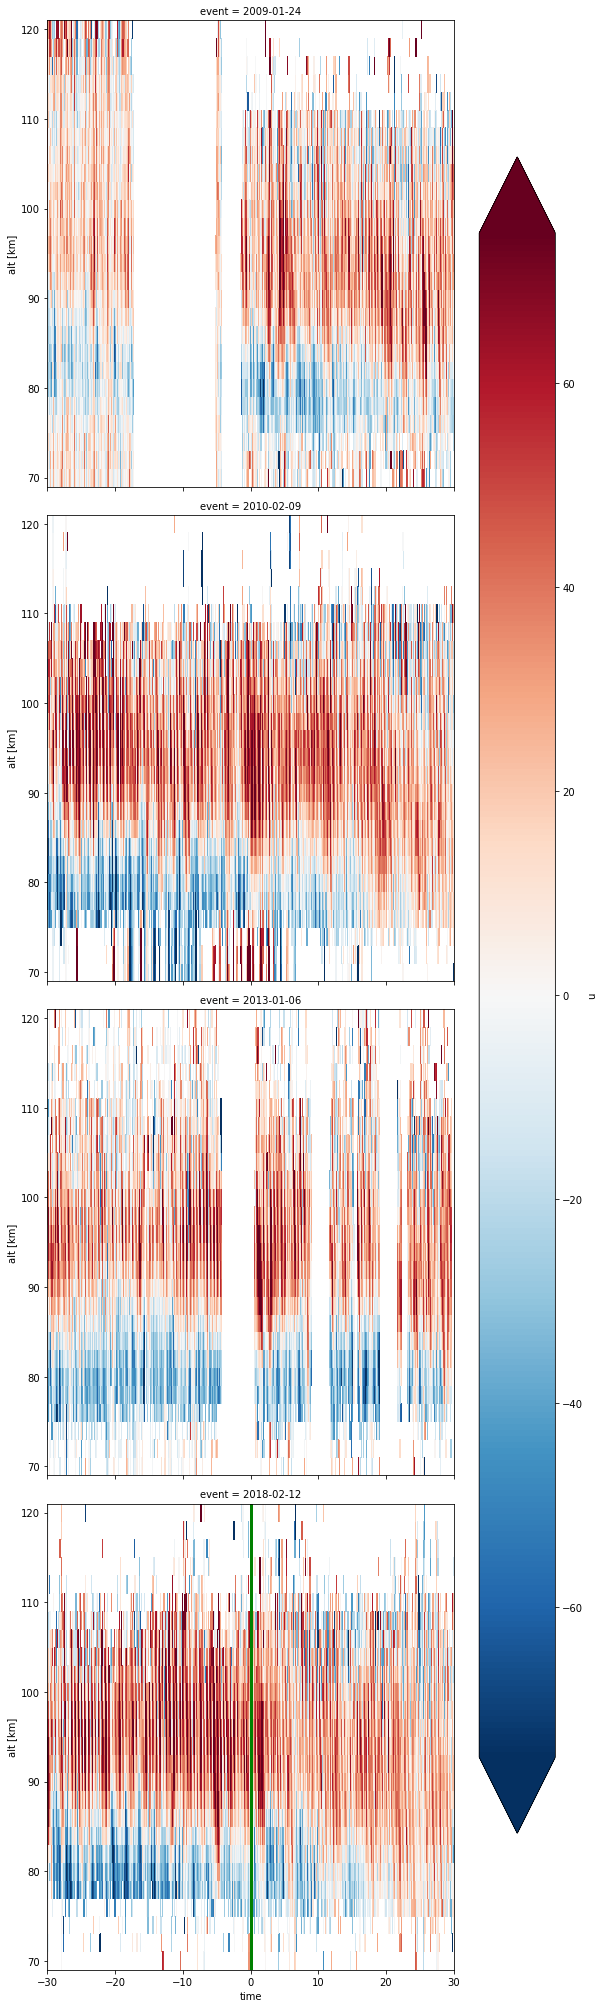

In [17]:
sea_u_rio_individual.plot(x="time", row="event", robust=True, size=7)
plt.vlines(0, 60, 130, color="g", lw=3)

In [18]:
sea_u_rio_individual

<xarray.DataArray 'u' (event: 4, time: 2879, alt: 26)>
dask.array<concatenate, shape=(4, 2879, 26), dtype=float64, chunksize=(1, 639, 26), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 -30.0 -29.96 -29.96 -29.92 ... 29.96 29.96 30.0
  * alt      (alt) int64 70 72 74 76 78 80 82 84 ... 108 110 112 114 116 118 120
  * event    (event) object '2009-01-24' '2010-02-09' '2013-01-06' '2018-02-12'
Attributes:
    zonal wind:  zonal / m/s

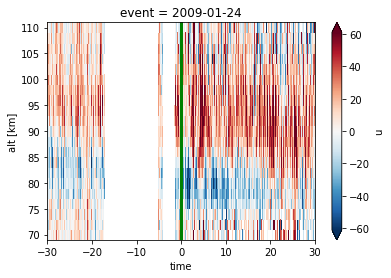

In [19]:
sea_u_rio_individual[0].sel(alt=slice(70, 110)).plot(x="time", robust=True)
plt.vlines(0, 60, 120, color="g", lw=3)

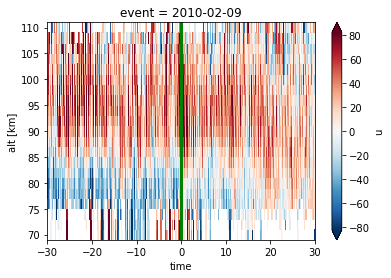

In [20]:
sea_u_rio_individual[1].sel(alt=slice(70, 110)).plot(x="time", robust=True)
plt.vlines(0, 60, 120, color="g", lw=3)

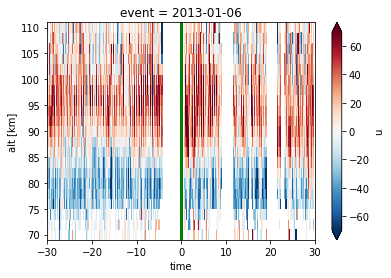

In [21]:
sea_u_rio_individual[2].sel(alt=slice(70, 110)).plot(x="time", robust=True)
plt.vlines(0, 60, 120, color="g", lw=3)

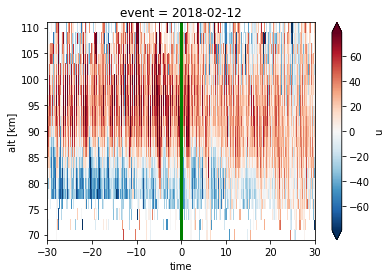

In [22]:
sea_u_rio_individual[3].sel(alt=slice(70, 110)).plot(x="time", robust=True)
plt.vlines(0, 60, 120, color="g", lw=3)

In [23]:
sea_u_rio_individual[4].sel(alt=slice(70, 110)).plot(x="time", robust=True)
plt.vlines(0, 60, 120, color="g", lw=3)

IndexError: Index is not smaller than dimension 4 >= 4

In [ ]:
sea_u_rio_individual[4].sel(alt=90, method="nearest").plot(x="time")

In [ ]:
sea_u_rio_individual[5].sel(alt=slice(70, 110)).plot(x="time", robust=True)
plt.vlines(0, 60, 120, color="g", lw=3)

In [ ]:
sea_u_rio_individual[6].sel(alt=slice(70, 110)).plot(x="time", robust=True)
plt.vlines(0, 60, 120, color="g", lw=3)

In [ ]:
sea_u_rio_individual[7].sel(alt=slice(70, 110)).plot(x="time", robust=True)
plt.vlines(0, 60, 120, color="g", lw=3)

In [ ]:
sea_u_rio_individual[8].sel(alt=slice(70, 110)).plot(x="time", robust=True)
plt.vlines(0, 60, 120, color="g", lw=3)